## Load data
https://github.com/andilabs/warszawa-dzielnice-geojson/blob/master/warszawa-dzielnice.geojson

In [51]:
import folium
import json
import numpy as np
import pandas as pd
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
filename = 'warszawa-dzielnice.geojson'
with open(filename, 'r',encoding='UTF-8') as f:
    datastore = json.load(f)

In [3]:
names = np.array([])
lats = np.array([])
longs = np.array([])
for i in range(1,len(datastore['features'])):
    name = datastore['features'][i]['properties']['name']
    coord = np.array(datastore['features'][i]['geometry']['coordinates'][0][0])
    lat = coord[:,1]
    long = coord[:,0]
    
    names = np.concatenate((names, np.repeat(name,long.shape)))
    lats = np.concatenate((lats, lat))
    longs = np.concatenate((longs, long))

In [4]:
warsaw_df = pd.DataFrame({'Neighborhood':names,'Lat':lats,'Long':longs})
warsaw_df.head()

,Neighborhood,Lat,Long
0,Ochota,52.228066,21.001524
1,Ochota,52.225520,20.990589
2,Ochota,52.225494,20.989872
3,Ochota,52.224734,20.987300
4,Ochota,52.223689,20.982241


### Calculate neighborhoods centers to get data from API

In [5]:
warsaw_df_centers = warsaw_df.groupby(['Neighborhood'], as_index=False).agg({'Lat': ['mean'], 'Long': ['mean']})
warsaw_df_centers.columns = ['Neighborhood','Lat','Long']
warsaw_df_centers

,Neighborhood,Lat,Long
0,Bemowo,52.239606,20.899061
1,Białołęka,52.328444,20.998763
2,Bielany,52.296865,20.929070
3,Mokotów,52.189544,21.047263
4,Ochota,52.214050,20.961090
5,Praga Południe,52.244749,21.074174
6,Praga Północ,52.265506,21.034593
7,Rembertów,52.259174,21.154148
8,Targówek,52.283011,21.047594
9,Ursus,52.195898,20.876551


## Load data from Foursquare API

In [6]:
CLIENT_ID = 'KI23FYWGJHJGO0TR2CFTFXFIAEIYDLBP30HCWZGD1X1IGO5U' # your Foursquare ID
CLIENT_SECRET = 'HPSDU0TUZ30Q0TMW4I5VUNMJSPA2IVPP3HHMCC4RHU01Z33E' # your Foursquare Secret
VERSION = '20200318' # Foursquare API version

In [7]:
radius = 5000
LIMIT = 100
venues = []

for lat, long, neighborhood in zip(warsaw_df_centers['Lat'], warsaw_df_centers['Long'], warsaw_df_centers['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    # make the GET request
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
    except:
        print('No venues for: ' + neighborhood)
        pass
        
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

No venues for: Ursynów
No venues for: Wawer


### Transform Foursquare data to Data Frame

In [8]:
venues_df = pd.DataFrame(venues, columns=['Neighborhood','VenueName','VenueLat','VenueLong','VenueCategory'])
print(venues_df.shape)
venues_df.head()

(1491, 5)


,Neighborhood,VenueName,VenueLat,VenueLong,VenueCategory
0,Bemowo,Zdrofit Bemowo,52.245641,20.906136,Gym / Fitness Center
1,Bemowo,Decathlon Bemowo,52.240792,20.891503,Sporting Goods Shop
2,Bemowo,Park Moczydło,52.241296,20.951679,Park
3,Bemowo,CieKawa,52.242059,20.913374,Café
4,Bemowo,Park Sowińskiego,52.230349,20.948138,Park


### Check the venues in Warsaw
I am not able to check all of the venues types. But I will try to remove all of the places where You can not eat.

In [15]:
venues_df = venues_df[venues_df['VenueCategory'] != 'Park']
venues_df = venues_df[venues_df['VenueCategory'] != 'Gym / Fitness Center']
venues_df = venues_df[venues_df['VenueCategory'] != 'Soccer Field']
venues_df = venues_df[venues_df['VenueCategory'] != 'Train Station']
venues_df = venues_df[venues_df['VenueCategory'] != 'Clothing Store']
venues_df = venues_df[venues_df['VenueCategory'] != 'Bus Station']
venues_df = venues_df[venues_df['VenueCategory'] != 'Climbing Gym']
venues_df = venues_df[venues_df['VenueCategory'] != 'Tram Station']

In [16]:
venues_df['VenueCategory'].value_counts()

Café                    84
Italian Restaurant      49
Coffee Shop             48
Hotel                   47
Supermarket             47
                        ..
Hobby Shop               1
Cantonese Restaurant     1
African Restaurant       1
Motel                    1
Zoo Exhibit              1
Name: VenueCategory, Length: 178, dtype: int64

## Load data about number of people living in neighborhoods

In [17]:
warsaw_people = pd.read_html('https://pl.wikipedia.org/wiki/Podzia%C5%82_administracyjny_Warszawy')[0]

In [18]:
warsaw_people.columns = ['Neighborhood','Residents','DensityOfResidents','Area']

In [19]:
warsaw_people.loc[warsaw_people['Neighborhood'] == 'Praga-Południe',['Neighborhood']] = 'Praga Południe'
warsaw_people.loc[warsaw_people['Neighborhood'] == 'Praga-Północ',['Neighborhood']] = 'Praga Północ'
warsaw_people['Residents'] = warsaw_people['Residents'].str.replace(' ','').astype(int)
warsaw_people.head()

,Neighborhood,Residents,DensityOfResidents,Area
0,Mokotów,217683,6146,3542
1,Praga Południe,179836,8036,2238
2,Ursynów,150668,3441,4379
3,Wola,140958,7319,1926
4,Bielany,131910,4079,3234


## Visualize dataset

In [21]:
m = folium.Map(location=[52.237049, 21.017532], zoom_start=10.5)

folium.Choropleth(
    geo_data=datastore,
    data=warsaw_people,
    columns=['Neighborhood', 'Residents'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity=0.2,
    legend_name='Number of residents in Warsaw'
).add_to(m)

folium.LayerControl().add_to(m)

for lat, lng, name, neighborhood in zip(venues_df['VenueLat'], venues_df['VenueLong'], venues_df['VenueName'], venues_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, name, encoding = 'UTF-8')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m)  
    
m

## K-means clustering of venues
I am doing that to create the "circles" of venues and see how many of them are in specific neighborhood. That will help to pick the best neighborhood to open new restaurant.

In [26]:
X = venues_df[['VenueLat','VenueLong']].values
X

array([[52.2407922 , 20.89150269],
       [52.24205921, 20.91337359],
       [52.21566574, 20.86138842],
       ...,
       [52.23213382, 21.0018569 ],
       [52.23782206, 21.00719708],
       [52.24195206, 21.01589001]])

### Elbow method
I will not use elbow method to select the best K parameter, because 5 its just too less.

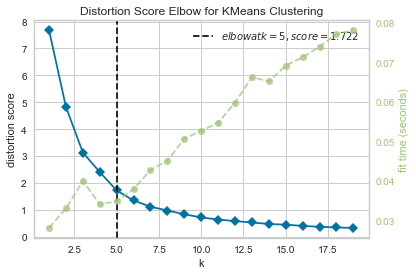

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Selecting K - parameter high enough to create venues "circles"

In [189]:
n_clusters = 50
model = KMeans(n_clusters=n_clusters)
model = model.fit(X)
labels = model.predict(X)
labels

array([41, 41, 18, ..., 22, 12, 12])

In [190]:
venues_df['cluster_label'] = labels
venues_df.head()

,Neighborhood,VenueName,VenueLat,VenueLong,VenueCategory,cluster_label
1,Bemowo,Decathlon Bemowo,52.240792,20.891503,Sporting Goods Shop,41
3,Bemowo,CieKawa,52.242059,20.913374,Café,41
6,Bemowo,Flyspot,52.215666,20.861388,Athletics & Sports,18
8,Bemowo,La Fiaccola,52.240811,20.912208,Italian Restaurant,41
9,Bemowo,Studio Transcolor,52.228329,20.872127,Concert Hall,11


In [191]:
# create map
m = folium.Map(location=[52.237049, 21.017532], zoom_start=10.5)

folium.Choropleth(
    geo_data=datastore,
    data=warsaw_people,
    columns=['Neighborhood', 'Residents'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity=0.2,
    legend_name='Number of residents in Warsaw'
).add_to(m)

folium.LayerControl().add_to(m)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_df['VenueLat'], venues_df['VenueLong'], venues_df['Neighborhood'], venues_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(m)
       
m

## Assign venues "circles" to neighborhoods

In [192]:
venues_df_agg = venues_df.groupby(['cluster_label'], as_index=False).agg({'VenueLat':['mean'],'VenueLong':['mean']})
venues_df_agg.columns = ['cluster_label','MeanVenueLat','MeanVenueLong']
venues_df_agg

,cluster_label,MeanVenueLat,MeanVenueLong
0,0,52.215935,20.978648
1,1,52.234767,21.107871
2,2,52.134286,21.065011
3,3,52.281838,20.946855
4,4,52.251175,21.012498
5,5,52.199672,20.870509
6,6,52.216997,21.236958
7,7,52.200610,21.019711
8,8,52.173343,20.936544
9,9,52.212748,21.163723


### Create shapely Polygons to determine the area

In [193]:
neighborhoods = warsaw_df['Neighborhood'].unique()

neighborhoods_polygons = {}
for neigh in neighborhoods:
    lats = warsaw_df[warsaw_df['Neighborhood']==neigh]['Lat']
    longs = warsaw_df[warsaw_df['Neighborhood']==neigh]['Long']

    
    points = []
    for lat,long in zip(lats,longs):
        points.append((lat,long))
    neighborhoods_polygons[neigh] = Polygon(points)

### Check every venue circle to which Polygon they belong

In [194]:
points = []
for i in range(venues_df_agg.shape[0]):
    lat = venues_df_agg.loc[i,['MeanVenueLat']].values[0]
    long = venues_df_agg.loc[i,['MeanVenueLong']].values[0]
    points.append(Point(lat,long))

In [195]:
neigh_list = [None]*n_clusters
for iter,point in enumerate(points):
    for neigh in neighborhoods_polygons.keys():
        if neighborhoods_polygons[neigh].contains(point):
            neigh_list[iter] = neigh

In [196]:
venues_df_agg['Neighborhood'] = neigh_list
venues_df_agg2 = venues_df_agg.groupby(['Neighborhood'], as_index=False).agg({'cluster_label':['count']})
venues_df_agg2.columns = ['Neighborhood','Count']
venues_df_agg2

,Neighborhood,Count
0,Bemowo,3
1,Białołęka,5
2,Bielany,3
3,Mokotów,4
4,Ochota,2
5,Praga Południe,4
6,Praga Północ,1
7,Rembertów,1
8,Targówek,2
9,Ursus,2


## Join number of cluster with number of residents and get final results

In [197]:
venues_df_agg3 = warsaw_people.merge(venues_df_agg2)
venues_df_agg3['ratio'] = (venues_df_agg3['Count'] / venues_df_agg3['Residents'])*10000
venues_df_agg3.sort_values(['ratio'], ascending = False)

,Neighborhood,Residents,DensityOfResidents,Area,Count,ratio
16,Wesoła,25439,1109,2294,2,0.786194
14,Włochy,42862,1497,2863,3,0.699921
7,Śródmieście,115395,7411,1557,6,0.519953
15,Wilanów,40060,1091,3673,2,0.499251
17,Rembertów,24328,1261,1930,1,0.411049
8,Białołęka,124125,1699,7304,5,0.402820
13,Żoliborz,52293,6174,847,2,0.382460
12,Ursus,60112,6422,936,2,0.332712
6,Bemowo,123932,4967,2495,3,0.242068
9,Ochota,82774,8516,972,2,0.241622
